# 01 — EDA

Objectif: vérifier que tout fonctionne et regarder rapidement les données.

In [ ]:
# Cellule 1 — Amorçage VS Code/Jupyter
# But: fixer les chemins, vérifier le kernel .venv, lister les CSV.
from pathlib import Path
import sys

# Racine projet (si le notebook est dans /notebooks, on remonte d'un cran)
ROOT = Path.cwd() if (Path.cwd() / "data" / "raw").exists() else Path.cwd().parent
RAW  = ROOT / "data" / "raw"

print("Python utilisé :", sys.executable)        # Doit contenir ".venv"
print("ROOT           :", ROOT)                   # Dossier projet7_scoring
print("RAW            :", RAW)                    # .../data/raw

# Lister les CSV présents
csvs = sorted(p.name for p in RAW.glob("*.csv"))
print("CSV trouvés    :", len(csvs))
print(csvs)

# Garde-fou minimal
assert RAW.exists(), "Le dossier data/raw est introuvable."
assert (RAW/"application_train.csv").exists(), "application_train.csv manquant dans data/raw."


Python utilisé : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\.venv\Scripts\python.exe
ROOT           : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter
RAW            : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\data\raw
CSV trouvés    : 10
['HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'previous_application.csv', 'sample_submission.csv']


Lignes, colonnes : (307511, 2)
Comptes par classe : {0: 282686, 1: 24825}
Prévalence (classe 1) : 8.07%


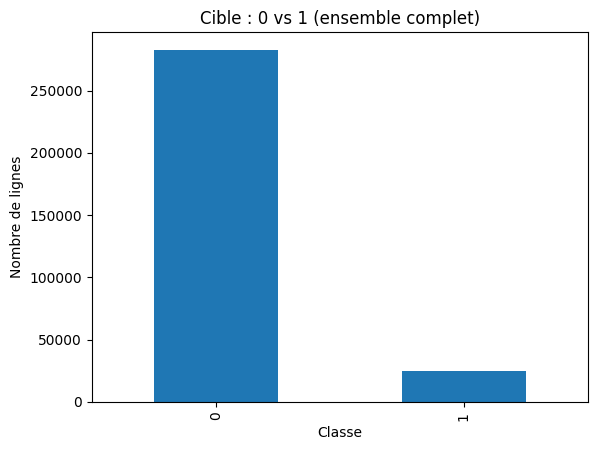

In [18]:
# Cellule 2 — Cible : 0 vs 1
import pandas as pd
import matplotlib.pyplot as plt

train = pd.read_csv(RAW/"application_train.csv", usecols=["SK_ID_CURR","TARGET"])
print("Lignes, colonnes :", train.shape)

vc = train["TARGET"].value_counts().sort_index()
prev = train["TARGET"].mean()

print("Comptes par classe :", vc.to_dict())
print(f"Prévalence (classe 1) : {prev:.2%}")

vc.plot(kind="bar")
plt.title("Cible : 0 vs 1 (ensemble complet)")
plt.xlabel("Classe")
plt.ylabel("Nombre de lignes")
plt.show()


In [19]:
# Cellule 3 — Features "bureau"
from pathlib import Path
import pandas as pd
from collections import Counter

# Chemins (réutilise ROOT/RAW si déjà définis)
ROOT = Path.cwd() if (Path.cwd()/"data"/"raw").exists() else Path.cwd().parent
RAW  = ROOT / "data" / "raw"
PROC = ROOT / "data" / "processed"
PROC.mkdir(parents=True, exist_ok=True)

# 1) Table maîtresse (léger)
train = pd.read_csv(RAW/"application_train.csv", usecols=["SK_ID_CURR","TARGET"])
print("train:", train.shape)

# 2) Compte des lignes de bureau_balance par SK_ID_BUREAU (lecture par morceaux)
bb_counts = Counter()
for chunk in pd.read_csv(RAW/"bureau_balance.csv", chunksize=500_000):
    vc = chunk["SK_ID_BUREAU"].value_counts()
    for k, v in vc.items():
        bb_counts[k] += int(v)
bb_per_bureau = pd.DataFrame({"SK_ID_BUREAU": list(bb_counts.keys()),
                              "bb_count": list(bb_counts.values())})
print("bb_per_bureau:", bb_per_bureau.shape)

# 3) Join vers bureau pour récupérer SK_ID_CURR
bureau = pd.read_csv(RAW/"bureau.csv", usecols=["SK_ID_CURR","SK_ID_BUREAU"])
bureau_enriched = bureau.merge(bb_per_bureau, on="SK_ID_BUREAU", how="left")
bureau_enriched["bb_count"] = bureau_enriched["bb_count"].fillna(0)

# 4) Agrégation au niveau client (2 features)
bureau_feat = (bureau_enriched
               .groupby("SK_ID_CURR")
               .agg(n_bureau=("SK_ID_BUREAU","count"),
                    n_bureau_months=("bb_count","sum"))
               .reset_index())
print("bureau_feat:", bureau_feat.shape)

# 5) Merge avec la table maîtresse + sauvegarde
train_plus = train.merge(bureau_feat, on="SK_ID_CURR", how="left").fillna(0)
print("train_plus:", train_plus.shape)

out_path = PROC / "train_plus_bureau.csv"
train_plus.to_csv(out_path, index=False)
print("Écrit :", out_path)


train: (307511, 2)
bb_per_bureau: (817395, 2)
bureau_feat: (305811, 3)
train_plus: (307511, 4)
Écrit : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\data\processed\train_plus_bureau.csv


In [20]:
# Cellule 4 — Features "previous_*" (compteurs simples par client) + sauvegarde
from pathlib import Path
import pandas as pd
from collections import Counter

# Chemins (robustes)
ROOT = Path.cwd() if (Path.cwd()/ "data" / "raw").exists() else Path.cwd().parent
RAW  = ROOT / "data" / "raw"
PROC = ROOT / "data" / "processed"
PROC.mkdir(parents=True, exist_ok=True)

# Repartir du fichier créé à l'étape précédente
base = pd.read_csv(PROC / "train_plus_bureau.csv")  # contient SK_ID_CURR, TARGET, n_bureau, n_bureau_months
print("base:", base.shape)

# Table "previous_application" (clé vers client et vers SK_ID_PREV)
prev = pd.read_csv(RAW / "previous_application.csv", usecols=["SK_ID_CURR","SK_ID_PREV"])
print("previous_application:", prev.shape)

# Fonction utilitaire: compter par SK_ID_PREV (lecture par morceaux pour limiter la RAM)
def count_by_prev(csv_filename, key="SK_ID_PREV", chunksize=500_000):
    cnt = Counter()
    for chunk in pd.read_csv(RAW / csv_filename, chunksize=chunksize):
        vc = chunk[key].value_counts()
        for k, v in vc.items():
            cnt[k] += int(v)
    return pd.DataFrame({key: list(cnt.keys()), "count": list(cnt.values())})

# Compteurs par SK_ID_PREV pour les 3 tables liées
inst = count_by_prev("installments_payments.csv"); inst.rename(columns={"count":"n_inst_pay"}, inplace=True)
posc = count_by_prev("POS_CASH_balance.csv");     posc.rename(columns={"count":"n_pos_cash"}, inplace=True)
ccb  = count_by_prev("credit_card_balance.csv");  ccb.rename(columns={"count":"n_ccb"}, inplace=True)
print("inst:", inst.shape, "posc:", posc.shape, "ccb:", ccb.shape)

# Joindre aux prev puis agréger au niveau client
prev_enriched = (prev
                 .merge(inst, on="SK_ID_PREV", how="left")
                 .merge(posc, on="SK_ID_PREV", how="left")
                 .merge(ccb,  on="SK_ID_PREV", how="left")
                 .fillna(0))

prev_feat = (prev_enriched
             .groupby("SK_ID_CURR")
             .agg(n_prev=("SK_ID_PREV","count"),
                  n_inst_pay=("n_inst_pay","sum"),
                  n_pos_cash=("n_pos_cash","sum"),
                  n_ccb=("n_ccb","sum"))
             .reset_index())

print("prev_feat:", prev_feat.shape)
display(prev_feat.head())

# Fusion finale avec la base et sauvegarde
final_df = base.merge(prev_feat, on="SK_ID_CURR", how="left").fillna(0)
print("final_df:", final_df.shape)

out_path = PROC / "train_plus_bureau_prev.csv"
final_df.to_csv(out_path, index=False)
print("Écrit :", out_path)

base: (307511, 4)
previous_application: (1670214, 2)
inst: (997752, 2) posc: (936325, 2) ccb: (104307, 2)
prev_feat: (338857, 5)


,SK_ID_CURR,n_prev,n_inst_pay,n_pos_cash,n_ccb
0,100001,1,4.0,5.0,0.0
1,100002,1,19.0,19.0,0.0
2,100003,3,25.0,28.0,0.0
3,100004,1,3.0,4.0,0.0
4,100005,2,9.0,11.0,0.0


final_df: (307511, 8)
Écrit : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\data\processed\train_plus_bureau_prev.csv


In [22]:
# Baseline simple sur 6 features de comptage + seuil auto
from pathlib import Path
import numpy as np, pandas as pd, json
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix, roc_auc_score, average_precision_score

ROOT = Path.cwd() if (Path.cwd()/ "data" / "processed").exists() else Path.cwd().parent
PROC = ROOT / "data" / "processed"
CFG  = ROOT / "config"; CFG.mkdir(exist_ok=True)

# 1) Charger les données enrichies
df = pd.read_csv(PROC / "train_plus_bureau_prev.csv")

# 2) Features simples (présentes) + cible
feat_cols = [c for c in ["n_bureau","n_bureau_months","n_prev","n_inst_pay","n_pos_cash","n_ccb"] if c in df.columns]
X = df[feat_cols].astype(float)
y = df["TARGET"].astype(int).values
print("Features utilisées:", feat_cols, "| Positifs (classe 1):", int(y.sum()))

# 3) Découpage (stratifié)
Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4) Modèle simple (imputation + standardisation + régression logistique pondérée)
pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])
pipe.fit(Xtr, ytr)
proba = pipe.predict_proba(Xva)[:,1]

# 5) Choix auto du meilleur seuil pour F1
prec, rec, thr = precision_recall_curve(yva, proba)
f1s = (2*prec*rec/(prec+rec+1e-12))[:-1]
best_i   = int(np.argmax(f1s))
best_thr = float(thr[best_i])
pred     = (proba >= best_thr).astype(int)

# 6) Résumé clair
tn, fp, fn, tp = confusion_matrix(yva, pred).ravel()
print(f"\nSeuil choisi (auto) : {best_thr:.3f}")
print(f"F1 (avec ce seuil)  : {f1_score(yva, pred):.3f}")
print(f"PR-AUC               : {average_precision_score(yva, proba):.3f}")
print(f"ROC-AUC              : {roc_auc_score(yva, proba):.3f}")
print("Erreurs :  TP=",tp," | FP=",fp," | FN=",fn," | TN=",tn)

# 7) Sauvegarde du seuil pour la suite
with open(CFG / "threshold.json","w") as f:
    json.dump({"threshold": best_thr}, f)
print("\nÉcrit :", CFG / "threshold.json")


Features utilisées: ['n_bureau', 'n_bureau_months', 'n_prev', 'n_inst_pay', 'n_pos_cash', 'n_ccb'] | Positifs (classe 1): 24825

Seuil choisi (auto) : 0.515
F1 (avec ce seuil)  : 0.178
PR-AUC               : 0.110
ROC-AUC              : 0.589
Erreurs :  TP= 1853  | FP= 14052  | FN= 3112  | TN= 42486

Écrit : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\config\threshold.json


In [23]:
# Étape 6A — Features simples depuis application_train + merge avec nos compteurs
from pathlib import Path
import numpy as np
import pandas as pd

ROOT = Path.cwd() if (Path.cwd()/ "data" / "raw").exists() else Path.cwd().parent
RAW  = ROOT / "data" / "raw"
PROC = ROOT / "data" / "processed"
PROC.mkdir(parents=True, exist_ok=True)

# 0) Charger notre base actuelle (contient TARGET + 6 compteurs)
base = pd.read_csv(PROC / "train_plus_bureau_prev.csv")  # (SK_ID_CURR, TARGET, n_*)
print("base:", base.shape)

# 1) Colonnes possibles dans application_train (on lit l'entête pour savoir ce qui existe)
hdr = pd.read_csv(RAW / "application_train.csv", nrows=0).columns
want = [
    "SK_ID_CURR","TARGET",
    "AMT_CREDIT","AMT_INCOME_TOTAL","AMT_ANNUITY","AMT_GOODS_PRICE",
    "DAYS_BIRTH","DAYS_EMPLOYED",
    "EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"
]
usecols = [c for c in want if c in hdr]
app = pd.read_csv(RAW / "application_train.csv", usecols=usecols)
print("app:", app.shape, "| colonnes lues:", usecols)

# 2) Features simples (créées seulement si les colonnes existent)
def has(*cols): 
    return all(c in app.columns for c in cols)

if has("AMT_CREDIT","AMT_INCOME_TOTAL"):
    app["credit_income_perc"] = app["AMT_CREDIT"] / app["AMT_INCOME_TOTAL"].replace(0,np.nan)

if has("AMT_ANNUITY","AMT_INCOME_TOTAL"):
    app["annuity_income_perc"] = app["AMT_ANNUITY"] / app["AMT_INCOME_TOTAL"].replace(0,np.nan)

if has("AMT_CREDIT","AMT_ANNUITY"):
    app["credit_term"] = app["AMT_CREDIT"] / app["AMT_ANNUITY"].replace(0,np.nan)

if has("AMT_GOODS_PRICE","AMT_CREDIT"):
    app["goods_credit_ratio"] = app["AMT_GOODS_PRICE"] / app["AMT_CREDIT"].replace(0,np.nan)

if has("DAYS_BIRTH"):
    app["age_years"] = -app["DAYS_BIRTH"] / 365.0

if has("DAYS_EMPLOYED"):
    # 365243 est une valeur spéciale = manquant → on met NaN
    app.loc[app["DAYS_EMPLOYED"] > 365000, "DAYS_EMPLOYED"] = np.nan
    app["employed_years"] = -app["DAYS_EMPLOYED"] / 365.0

# 3) Garder seulement SK_ID_CURR, TARGET et nos nouvelles colonnes
keep = ["SK_ID_CURR","TARGET"] + [c for c in [
    "credit_income_perc","annuity_income_perc","credit_term","goods_credit_ratio",
    "age_years","employed_years","EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3"
] if c in app.columns]
app_feat = app[keep].copy()
print("app_feat:", app_feat.shape)

# 4) Merge avec la base (niveau client) — on laisse les NaN (imputation par le modèle)
final = base.merge(app_feat, on=["SK_ID_CURR","TARGET"], how="left")
print("final:", final.shape)

out = PROC / "train_features_v1.csv"
final.to_csv(out, index=False)
print("Écrit :", out)


base: (307511, 8)
app: (307511, 11) | colonnes lues: ['SK_ID_CURR', 'TARGET', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
app_feat: (307511, 11)
final: (307511, 17)
Écrit : c:\Users\FFix\Desktop\Formation Data Science\Projects\OpenClassroom\Project 07\projet7_starter\data\processed\train_features_v1.csv
